IPSL-CM6A-LR, CNRM-ESM2-1, UKESM1-0-LL, CMCC-ESM2

In [1]:
import gcsfs
import cftime
import intake
from cmip6_preprocessing.preprocessing import combined_preprocessing
from xgcm import Grid
import numpy as np
import xesmf as xe
import xarray as xr
import pandas as pd

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6-noQC.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(table_id='Omon', 
                 experiment_id=['historical'],
                 variable_id=['thetao'],
                 member_id=['r1i1p1f1'],
                 grid_label='gn',
                 source_id=['CMCC-ESM2']
                )


In [3]:
cmip6_compiled = cat.to_dataset_dict(
            zarr_kwargs={'consolidated':True, 'decode_times':True, 'use_cftime': True},
            preprocess=combined_preprocessing
            )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/Users/odyssey/miniconda3/envs/test_intake/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/odyssey/miniconda3/envs/test_intake/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return 

## Regrid CMIP6 data to observational dataset grid

Download observational grid

In [4]:
URL = 'https://ds.nccs.nasa.gov/thredds/dodsC/bypass/CREATE-IP/reanalysis/CFSR/mon/ocean/thetao.ncml'
CFSR_thetao = xr.open_dataset(URL,engine='netcdf4')

lat = CFSR_thetao.lat
lon = CFSR_thetao.lon

obs_grid = xr.Dataset(
    {
        "lat": (["lat"], lat),
        "lon": (["lon"], lon),
    }
)

In [5]:
cmip6_compiled

{'CMIP.CMCC.CMCC-ESM2.historical.Omon.gn': <xarray.Dataset>
 Dimensions:        (bnds: 2, lev: 50, member_id: 1, time: 1980, vertex: 4, x: 292, y: 362)
 Coordinates: (12/15)
   * x              (x) float64 253.0 253.0 253.0 253.0 ... 254.3 254.4 254.5
   * y              (y) float64 50.01 50.12 50.23 50.51 ... 89.37 89.66 89.74
     lat            (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
   * lev            (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
     lev_bounds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
     lon            (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
     ...             ...
     lon_verticies  (x, y, vertex) float64 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
   * bnds           (bnds) int64 0 1
   * vertex         (vertex) int64 0 1 2 3
     lon_bounds     (bnds, x, y) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
     lat_bounds     (bnds, x, y) float64 

In [6]:
ds = cmip6_compiled['CMIP.CMCC.CMCC-ESM2.historical.Omon.gn']

Regrid CMIP6 data to CFSR

In [7]:
regridder = xe.Regridder(ds,obs_grid, 'nearest_s2d')
ds_regridded = regridder(ds)

/Users/odyssey/miniconda3/envs/test_intake/lib/python3.7/site-packages/xesmf/frontend.py:499: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


In [8]:
ds_regridded

<xarray.Dataset>
Dimensions:      (bnds: 2, lat: 360, lev: 50, lon: 720, member_id: 1, time: 1980, vertex: 4)
Coordinates:
  * lev          (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * bnds         (bnds) int64 0 1
  * vertex       (vertex) int64 0 1 2 3
  * member_id    (member_id) <U8 'r1i1p1f1'
  * lon          (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat          (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    thetao       (member_id, time, lev, lat, lon) float64 dask.array<chunksize=(1, 6, 50, 360, 720), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d

In [9]:
lon_min = 230
lon_max = 250
lat_min = 30
lat_max = 45

In [10]:
ds_subset_plot = ds_regridded.thetao.sel(lon=slice(lon_min,lon_max),
                                lat=slice(lat_min,lat_max), 
                                time=slice('1985-01-01','1986-01-01')).interp(lev=200).mean(dim='time').squeeze()


/Users/odyssey/miniconda3/envs/test_intake/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


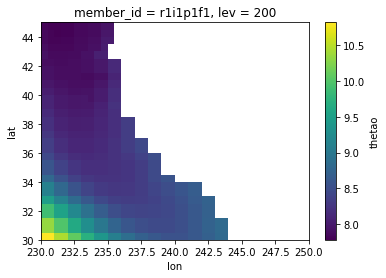

In [11]:
ds_subset_plot.plot()